In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

# Task 1:

One of the key challenges for digital subscription businesses is managing subscriber churn. Identifying patterns in our user data that will help keep members subscribed longer will be one of the key tasks for our new Business Intelligence Data Scientist. How would you go about this? Assume you have user data for each active and expired membership at your disposal (when they joined, what annual or monthly plan they were on, which article or landing page they converted off of, if and when they cancelled, what content they were engaging with on our site, their email addresses and locations). Please make sure your response addresses the following questions:

#### Question 1: 
Identifying patterns in user data that will help keep members subscribed longer.
#### Answer 1: 
1. *Recommendation engines*: I would employ content-based filtering or collaborative-filtering based on the available data. <br>
1a. *Content-based filtering* will recommend a new content based on user's preferred content. Approach needs more user preference data in order to incorporate best match. <br>
1b. *Collaborative filtering* will find users with similar content preferences and recommend new reading content to a user based on popularity with neighbourhood group. Approach needs large dataset with active users and their reading preferences <br><br>
2. *Behavioral customer segment*: I would employ clustering techniques on behavioral and demographics data such as locations, amount of product usage, source of conversion (landing page/article) etc. to find segments especially at-risk churning and study the behavioral characteristics<br><br>
3. *Cross-sell/Up-sell/Repeat purchase*: I would employ Market Basket Analysis to find associations between related content and recommend to user. Additionally, targeted marketing through recency-frequency-monetary analysis will help engage customers at-risk with appropriate offers.

#### Question 2: 
How would you categorize different types of reasons for churn (qualitatively)? Which ones can be addressed, and which ones cannot?
#### Answer 2: 
Different types of reasons of churn:
1. *Contractual Churn* - when users decide not to continue/renew with their expired subscriptions. <br><br>
2. *Voluntary Churn* - when users cancel their existing service. This can be further divided into:<br>
2a. *Product Usability Churn* - when users fail to encounter the “aha” moment in initial engagement days. “aha” moment is the instant when users understand the value of product <br>
2b. *High Price Churn* - when users find lower prices at competitors <br><br>
3. *Payment Failure Churn* - when users experience friction transacting with the product, which eventually discourages them from further engagement<br><br>
4. *Unavoidable churn*: While all above are avoidable churn, some unavoidable churn can be: <br><br>
4a. *Missing Product Feature Churn* [Addressable] - when users leave because they seek a particular product functionality, not developed in BI Prime yet. Note: This churn can be addressed by aligining product development road map with customer needs <br>
4b. *Involuntary churn* [Unaddressable] - when users (organizations) go out of business or individual users can't pay for subscriptions due to financial hardships.

*Reference:*

[Facebook's aha moment and how to find it](https://mode.com/blog/facebook-aha-moment-simpler-than-you-think/)

#### Question 3:
How would you go about identifying and measuring these categories analytically, in your dataset?
#### Answer 3: 
by looking at what your current customers did in your app that your churned customers didn’t do. 
1. *Contractual Churn* - **Identify**: # of users not renewing monthly/annual subscriptions. **Measure**: Track contract renewal rate.<br><br> 
2. Voluntary Churn - <br>
2a. Product Usability Churn - **Identify**: find set of actions such that majority of users who took the action were retained. Example - sharing BI articles on user's social media. **Measure**: Count # of new users who took the "aha" action.<br>
2b. High Price Churn - **Identify**: User exit-survey. **Measure**: # Users who gave the reason of leaving as High product price. And calculate Product ROI for customers and advertise the cost/time save<br><br>
3. Payment Failure Churn - **Identify**: trasaction processing status **Measure**: # transactions with failed status and reason as 'payment failure'

# Task 2:
In this example, we’d like you to analyze subscriber data to predict an average customer lifetime. Using the data in the attached spreadsheet, please create a model that calculates the length of an expected average customer lifespan.

### Step 1: Data cleaning

In [2]:
# read the data

subscriber_data = pd.read_csv("BI Prime Business Intelligence Assessment - Spreadsheet.csv",skiprows=[0])
subscriber_data.head()

,TransactionID,Transaction Start Date,User ID,Status,Term Type,Transaction Cancellation Date,Transaction Expiration Date,Auto Renew Enabled,Device
0,RC14CMFB6V8H,1/29/2020,PNI0jcBiqpzup4j,active,Annual,NaN,1/29/2021,True,desktop
1,RC398GWGYZDO,1/29/2020,PNI3aN2bKq4vuuq,active,Monthly,NaN,2/29/2020,True,external
2,RCTQ714GQUIY,1/29/2020,PNIuFEFXtq4vulx,active,Annual,NaN,1/29/2021,True,desktop
3,RCD6KKVUNOPO,1/29/2020,PNIk0Ohaeq4vuhq,active,Monthly,NaN,2/29/2020,True,mobile
4,RC3G31HTZPWX,1/29/2020,PNIwQfeGuq4vuk3,active,Monthly,NaN,2/29/2020,True,desktop


In [3]:
print("# of rows and columns in data set: ", subscriber_data.shape)
print("# of Unique users: ", len(subscriber_data["User ID"].unique()))
print("# of Unique transactions: ", len(subscriber_data["TransactionID"].unique()))

# of rows and columns in data set:  (98351, 9)
# of Unique users:  92603
# of Unique transactions:  98351


**Observation: Duplicates present** <br>

In [4]:
subscriber_fullDups = subscriber_data[subscriber_data.duplicated(subset = ['Transaction Start Date', 'User ID', 'Status',
                                                                      'Term Type', 'Auto Renew Enabled', 
                                                                      'Transaction Cancellation Date', 'Device', 
                                                                      'Transaction Expiration Date'] , keep = False)]
subscriber_fullDups.head(6)

# There are 176 transaction IDs which contain duplicate entries across all columns. 
# These duplicate rows will not provide any new information. Hence, I will de-dupe these records. 

,TransactionID,Transaction Start Date,User ID,Status,Term Type,Transaction Cancellation Date,Transaction Expiration Date,Auto Renew Enabled,Device
5305,RC4H9SQQGO6T,1/8/2020,PNIFREaSbpxafra,active,Monthly,NaN,2/8/2020,True,desktop
5314,RCB7LRDDGOR6,1/8/2020,PNIFREaSbpxafra,active,Monthly,NaN,2/8/2020,True,desktop
6229,RCWSXRECOWME,1/3/2020,PNIqbyBm9q3j8lm,active,Monthly,NaN,2/3/2020,True,mobile
6230,RC94ECAVE9EZ,1/3/2020,PNIqbyBm9q3j8lm,active,Monthly,NaN,2/3/2020,True,mobile
9171,RCK09PU096SM,12/17/2019,PNI2IPtjvq2nszh,active,Monthly,NaN,2/17/2020,True,desktop
9176,RCPYNUHL2Q1K,12/17/2019,PNI2IPtjvq2nszh,active,Monthly,NaN,2/17/2020,True,desktop


In [5]:
# delete the duplicate entries and keep just one
dedupe_1 = subscriber_data.drop_duplicates(['Transaction Start Date', 'User ID', 'Status',
                                                                      'Term Type', 'Auto Renew Enabled', 
                                                                      'Transaction Cancellation Date', 'Device', 
                                                                      'Transaction Expiration Date'], keep = 'first')
print("Shape after first de-duplication: ", dedupe_1.shape)
print("# unique users: ", len(dedupe_1["User ID"].unique()))

Shape after first de-duplication:  (98251, 9)
# unique users:  92603


**Observation:** <br>
Further I noted that there are 146 transaction IDs which contain same information under the combination of columns - ['Transaction Start Date', 'User ID', 'Term Type', 'Transaction Expiration Date']. Duplication in these four columns may mean that they represent the exact same transaction. <br><br>
*Example*: First and second row in below table contain same information in the said 4 columns. The only difference is in 'Auto Renew Enabled' (values given - True/False). This might have been an issue while recording the data. <br><br>
*Solution*: To de-dupe them, I will keep the first occurence and delete the rest of the duplicates. (Note: The decision to keep the first occurence is for the sake of simplicity. More advanced data cleaning steps can be applied in future like imputing the median value for ['Auto Renew Enabled', 'Device'] columns.

In [6]:
subscriber_partialDups = dedupe_1[dedupe_1.duplicated(['Transaction Start Date', 'User ID', 'Term Type', 
                                                      'Transaction Expiration Date'], keep = False)]
# subscriber_partialDups.head(6)

dedupe_2 = dedupe_1.drop_duplicates(['Transaction Start Date', 'User ID', 'Term Type', 
                                  'Transaction Expiration Date'], keep = 'first')
print("Shape after final de-duplication: ", dedupe_2.shape)
print("# unique users: ",len(dedupe_2["User ID"].unique()))
# removed total 173 rows with duplicate/questionable entries

Shape after final de-duplication:  (98178, 9)
# unique users:  92603


**Observation:** <br>
1. There are 87,684 users with only single transactions in the data set. <br><br>
2. There are 4,919 users with multiple transactions, with total transaction records being 10,494. This group consists of users who have performed multiple actions such as upgrading/cancelling then activating their subscriptions. <br><br>
3. *Note:* I will concentrate on the 87,684 users in the below analysis because of assessment time constraint and single transaction users form the larger part of the data. Also, users with multiple transactions will need separate data pre-processing for calculating accurate duration of their subscriptions (as listed at the end of the notebook). 

In [7]:
# separating single transaction users
user_groups = pd.DataFrame(dedupe_2.groupby(['User ID'])['TransactionID'].count()).reset_index()
unique_userIDs = user_groups.loc[user_groups.TransactionID == 1]
unique_userIDs.drop("TransactionID", axis = 1, inplace = True)

# separating multiple transaction users
multiple_userIDs = user_groups.loc[user_groups.TransactionID > 1]
multiple_userIDs.drop("TransactionID", axis = 1, inplace = True)
print("# users with unique transaction records: ", unique_userIDs.shape)
print("# users with multiple transaction records: ", len(multiple_userIDs))

# users with unique transaction records:  (87684, 1)
# users with multiple transaction records:  4919


**Following is the portion of the data, I will use for further analysis and modeling average customer life span**

In [8]:
unique_user_trans = pd.merge(unique_userIDs, dedupe_2, how='inner', on=['User ID'])
unique_user_trans.head()

,User ID,TransactionID,Transaction Start Date,Status,Term Type,Transaction Cancellation Date,Transaction Expiration Date,Auto Renew Enabled,Device
0,000AbmTw6q,RC4A4H7KLI18,7/14/2018,cancelled,Monthly,7/14/2018,7/14/2018,True,mobile
1,00RBYcJVMs,RC35LK40H68S,4/3/2019,payment failure,Monthly,NaN,5/10/2019,True,desktop
2,00nmxJnuwg,RCXHNBEV44K8,3/24/2018,payment failure,Monthly,NaN,3/3/2019,False,mobile
3,01IxjKJVBH,RCJ3ZEBGXRFI,2/1/2018,cancelled,Monthly,3/9/2018,3/9/2018,True,desktop
4,01ini38hux,RC38TQISDG95,7/20/2019,expired,Monthly,NaN,8/20/2019,False,external


In [9]:
# needs further processing to calculate accurate subscription duration - will not be using

multiple_user_trans = pd.merge(multiple_userIDs, dedupe_2, how='inner', on=['User ID'])
print("# rows and columns: ", multiple_user_trans.shape)

multiple_user_trans.head()

# rows and columns:  (10494, 9)


,User ID,TransactionID,Transaction Start Date,Status,Term Type,Transaction Cancellation Date,Transaction Expiration Date,Auto Renew Enabled,Device
0,00RLHiXotB,RCQ17WOMH70E,8/16/2019,active,Annual,NaN,8/16/2020,True,desktop
1,00RLHiXotB,RCX3DOCS003B,6/12/2019,expired,Monthly,NaN,8/12/2019,True,desktop
2,00aPliEDEN,RCK9E662EQZ8,9/13/2019,expired,Monthly,NaN,1/13/2020,True,desktop
3,00aPliEDEN,RCF2MXO2ARVM,8/6/2018,cancelled,Monthly,8/30/2018,8/30/2018,True,desktop
4,010lg0SMZO,RC66S3L7V1CM,11/19/2019,expired,Monthly,NaN,12/19/2019,False,mobile


### Concepts:

Calculation of averge customer lifetime can be done using 'survival analysis' where:<br>
1. Event: Customer churned (I will create a new column with this information)
2. Time line: The time from the beginning of an observation period (subsription start time) to its end (subscription end time or today's date, which signifies end of study)
3. Right-Censoring: There are users who haven’t encountered the event (subscription termination) during the observation time. This makes the data right-censored.
<br>

[More on types of censoring](https://blog.minitab.com/blog/michelle-paret/the-difference-between-right-left-and-interval-censored-data)

* NOTE - I solved using survival analysis because I had done a survival project in school

### Step 2: Data Pre-processing

In [10]:
# convert the date columns from string to datetime, for further manipulation

unique_user_trans['Transaction Start Date'] = pd.to_datetime(unique_user_trans['Transaction Start Date'])
unique_user_trans['Transaction Cancellation Date'] = pd.to_datetime(unique_user_trans['Transaction Cancellation Date'])
unique_user_trans['Transaction Expiration Date'] = pd.to_datetime(unique_user_trans['Transaction Expiration Date'])

In [11]:
unique_user_trans["Status"].value_counts()

active             41371
expired            29344
payment failure    10427
cancelled           6514
won't renew           28
Name: Status, dtype: int64

#### Assumptions related to the data:

1. For active users, I will consider the difference between today's date (3rd July 2020) and corresponding transaction start date for calculating length of their subscription. <br><br>
2. For [Expired, Payment Failure and Won't renew] transactions, use the expiration date as time of event. <br>This is based on my assuption/intuition as the data file said *Transaction Expiration Date means the End Date of subscription transaction (past) or when it is set to end automatically (future) if not renewed*.

In [12]:
# following function calculates duration/tenure of subscription in DAYS. 

def calculate_days(row):
    """
    Logic for choosing subscription end date:
    
    1. Cancelled transactions :: use the cancellation date as time of event
    2. [Expired, Payment Failure and Won't renew] transactions :: use the expiration date as time of event
    3. Active transactions :: Event has not occured. So subcription duration is calculated till today's date. 

    """
    
    if row['Status'] == "cancelled":
        val = (row['Transaction Cancellation Date'] - row['Transaction Start Date'])/np.timedelta64(1, 'D')
    
    elif row['Status'] == "expired" or row['Status'] == "payment failure" or row['Status'] == "won't renew":
        val = (row['Transaction Expiration Date'] - row['Transaction Start Date'])/np.timedelta64(1, 'D')
    
    elif row['Status'] == "active":
        val = (pd.to_datetime(today) - row['Transaction Start Date'])/np.timedelta64(1, 'D')
    
    else:
        val = 0
        
    return int(val)

# new column with tenure in days
unique_user_trans['Tenure'] = unique_user_trans.apply(calculate_days, axis=1)

# all users who are not active have been labelled as churned. Note - decision based on intuition. 

unique_user_trans['Churn'] = np.where(unique_user_trans['Status']=='active', 0, 1)

In [13]:
unique_user_trans

# dataframe is ready for use

,User ID,TransactionID,Transaction Start Date,Status,Term Type,Transaction Cancellation Date,Transaction Expiration Date,Auto Renew Enabled,Device,Tenure,Churn
0,000AbmTw6q,RC4A4H7KLI18,2018-07-14,cancelled,Monthly,2018-07-14,2018-07-14,True,mobile,0,1
1,00RBYcJVMs,RC35LK40H68S,2019-04-03,payment failure,Monthly,NaT,2019-05-10,True,desktop,37,1
2,00nmxJnuwg,RCXHNBEV44K8,2018-03-24,payment failure,Monthly,NaT,2019-03-03,False,mobile,344,1
3,01IxjKJVBH,RCJ3ZEBGXRFI,2018-02-01,cancelled,Monthly,2018-03-09,2018-03-09,True,desktop,36,1
4,01ini38hux,RC38TQISDG95,2019-07-20,expired,Monthly,NaT,2019-08-20,False,external,31,1
...,...,...,...,...,...,...,...,...,...,...,...
87679,zyaJiY2s35,RCLYH42P06I8,2018-01-05,cancelled,Monthly,2018-03-09,2018-03-09,True,desktop,63,1
87680,zyoZ265aiD,RCK3T2AF7CMN,2017-12-15,cancelled,Monthly,2018-02-16,2018-02-16,True,desktop,63,1
87681,zyx1g3TBKh,RCZ686OP1CUW,2017-12-27,cancelled,Monthly,2017-12-27,2018-01-27,True,desktop,0,1
87682,zzKlmFTYky,RCOJCX6CBSNW,2018-06-23,active,Monthly,NaT,2020-01-30,True,mobile,741,0


### Step 3: Data Exploration/Preliminary Analysis


* **Observations:**
    * Lots of people with 1-month, 2- and 6-month durations. Then it drops off

<AxesSubplot:>

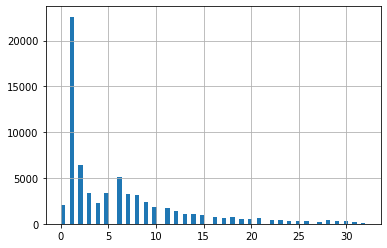

In [14]:
round(unique_user_trans[unique_user_trans["Term Type"]=="Monthly"]["Tenure"]/30).hist(bins=70)

* Lots of people w/ 1-year duration with BI. 
* Followed by those w/ 2-year durations

<AxesSubplot:>

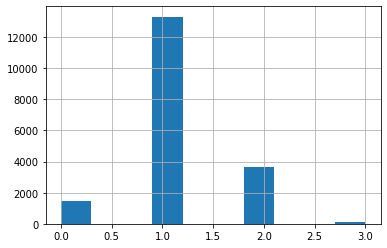

In [15]:
round(unique_user_trans[unique_user_trans["Term Type"]=="Annual"]["Tenure"]/365).hist()

In [16]:
# example of person with 1 year tenure

unique_user_trans.loc[87643]

User ID                                   zo26Yri8UE
TransactionID                           RCRNGKUD735V
Transaction Start Date           2018-07-16 00:00:00
Status                                       expired
Term Type                                     Annual
Transaction Cancellation Date                    NaT
Transaction Expiration Date      2019-07-16 00:00:00
Auto Renew Enabled                             False
Device                                         other
Tenure                                           365
Churn                                              1
Name: 87643, dtype: object

In [17]:
print("Min subscription start date: ", unique_user_trans['Transaction Start Date'].min().date(), "\nMax subscription end date: ", unique_user_trans['Transaction Expiration Date'].max().date())

Min subscription start date:  2017-11-01 
Max subscription end date:  2022-02-28


* 78% of people in dataset are monthly subscirbers

In [18]:
unique_user_trans["Term Type"].value_counts()

Monthly    69117
Annual     18567
Name: Term Type, dtype: int64

* Half of the people have churned in dataset

In [19]:
unique_user_trans["Churn"].value_counts(normalize=True)

1    0.528181
0    0.471819
Name: Churn, dtype: float64

* Churn rate is higher with Monthly subscriptions

In [20]:
pd.DataFrame(unique_user_trans.groupby("Term Type")["Churn"].value_counts(normalize=True)).sort_index()

Churn
Term Type Churn          
Annual    0      0.926806
          1      0.073194
Monthly   0      0.349596
          1      0.650404

#### Kaplan Myer Estimate 
1. Get an aggregated view of how long someone is going to be a customer typically (average). 
2. Compare the overall survival rates of monthly and yearly subscriber cohorts.
3. Take a simplistic approach to model only the survival time (without any other impacting variables)
<br><br>

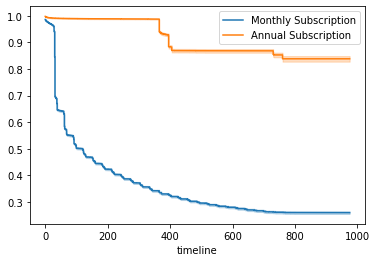

In [16]:
# Note: Kaplan-Meier curve can be used when every user can have only a single “birth” (subscription activation) and a single “death” (regardless of whether it is observed or not) event. 
# Since the data set I am using only has single record for each user, I will go ahead and fit KM curve below.

# create a kmf object
kmf = KaplanMeierFitter() 

T = unique_user_trans['Tenure']   
E = unique_user_trans['Churn']

groups = unique_user_trans['Term Type']   
i1 = (groups == 'Monthly')      ## group i1 , having the pandas series  for the 1st cohort
i2 = (groups == 'Annual')     ## group i2 , having the pandas series  for the 2nd cohort

# fit the model for 1st cohort
kmf.fit(T[i1], E[i1], label='Monthly Subscription')
a1 = kmf.plot()

# fit the model for 2nd cohort
kmf.fit(T[i2], E[i2], label='Annual Subscription')
kmf.plot(ax=a1)

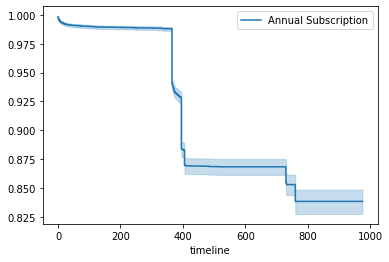

In [17]:
# get a better look at annual subscribers
# Note: the flat lines correspond to 365 days (a year), which is the length of annual subscription.
# Hence, there is no decrease in survival rate during that time

kmf.fit(T[i2], E[i2], label='Annual Subscription')
a2 = kmf.plot()

**Observations:**
1. Survival probability of annual subscribers is more than monthly subscribers. <br><br>
2. For monthly subscribers, the survival probability is decreasing with high rate during initial 200 days (~6 months) and it gets relatively better after that. <br><br>
3. For annual subscribers, the rate of decrease in survival rate is dramatic after 1st year compared to the decrease after 2nd year. Indicating that there is a high probability of people churning after 1st year and the rate decreases after 2nd year. <br><br>
4. **Business Recommendation**: Monthly cohort = efforts should be made to retain them in initial 6 volatile months. Yearly cohort = effort should be made to retain them towards the end of their 1st Annual membership.

### Step 4: Modeling

* **CoxPH Model:**
    * Much like linear regression - Modeling 101
    
    * A single individual can have multiple actions on the same account. Hence they show up in the dataset more than once. The clustering characteristic of CoxPH can handle this by specifying additional parameters.
    * The "Cancelled transactions" have same subscription start and expirate dates. This introduces zeros in durations. CoxPH model can handle this situation
* **Con** - used for small dimension data. Doesnt scale well for high-dimension. For high-dimension use ML

In [21]:
unique_user_modelDF = unique_user_trans[["Term Type", "Auto Renew Enabled", "Device", "Tenure","Churn"]]
unique_user_modelDF.head()

,Term Type,Auto Renew Enabled,Device,Tenure,Churn
0,Monthly,True,mobile,0,1
1,Monthly,True,desktop,37,1
2,Monthly,False,mobile,344,1
3,Monthly,True,desktop,36,1
4,Monthly,False,external,31,1


In [22]:
df_dummy = pd.get_dummies(unique_user_modelDF, drop_first=True)
df_dummy["Auto Renew Enabled"] = df_dummy["Auto Renew Enabled"].astype(int)
df_dummy.head()

,Auto Renew Enabled,Tenure,Churn,Term Type_Monthly,Device_external,Device_mobile,Device_other,Device_tablet
0,1,0,1,1,0,1,0,0
1,1,37,1,1,0,0,0,0
2,0,344,1,1,0,1,0,0
3,1,36,1,1,0,0,0,0
4,0,31,1,1,1,0,0,0


In [23]:
corr = df_dummy.corr()
corr.style.background_gradient(cmap='PuBu')

# there is no strong correlation present (which will need to be treated)

,Auto Renew Enabled,Tenure,Churn,Term Type_Monthly,Device_external,Device_mobile,Device_other,Device_tablet
Auto Renew Enabled,1.000000,0.000650,-0.034302,-0.009959,-0.016950,0.005023,0.001480,0.000801
Tenure,0.000650,1.000000,-0.659394,-0.403603,-0.068065,-0.027643,0.019593,0.058130
Churn,-0.034302,-0.659394,1.000000,0.472387,0.120510,-0.045234,-0.012857,-0.035840
Term Type_Monthly,-0.009959,-0.403603,0.472387,1.000000,0.027568,0.062320,-0.039294,-0.046971
Device_external,-0.016950,-0.068065,0.120510,0.027568,1.000000,-0.142197,-0.006792,-0.038318
Device_mobile,0.005023,-0.027643,-0.045234,0.062320,-0.142197,1.000000,-0.018400,-0.103805
Device_other,0.001480,0.019593,-0.012857,-0.039294,-0.006792,-0.018400,1.000000,-0.004958
Device_tablet,0.000801,0.058130,-0.035840,-0.046971,-0.038318,-0.103805,-0.004958,1.000000


### Step 4a: Train the model

In [21]:
cph = CoxPHFitter().fit(df_dummy, 'Tenure', 'Churn')

#cph.check_assumptions(df_dummy, p_value_threshold=0.05)
cph.print_summary()

**Observation**:
1. The Concordance index is 0.67. Usually, the real-world fitted models have a concordance index between 0.55 and 0.7 which is due to the noise present in the data.
2. All the variables are significant except 'Device_other'

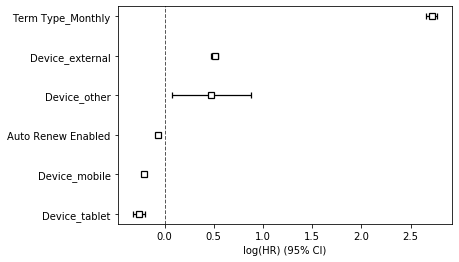

In [22]:
cph.plot()

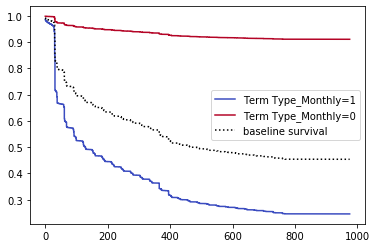

In [23]:
cph.plot_covariate_groups('Term Type_Monthly', [1,0], cmap='coolwarm')

### Step 4b: Test the model

Predicted median customer life span (in days)
5    123.0
6     99.0
7    184.0
8    219.0
9    219.0
Name: 0.5, dtype: float64


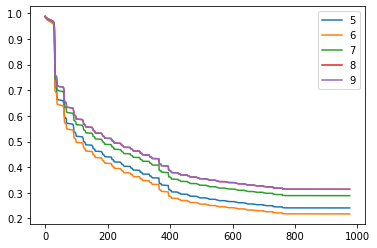

In [24]:
tr_rows = df_dummy.iloc[5:10] #randomly select candidates for prediction
tr_rows

print("Predicted median customer life span (in days)")
print(cph.predict_median(tr_rows))

# Predict the survival curve. Customers can be identified with the numbers mentioned against each curve.
cph.predict_survival_function(tr_rows).plot()

In [53]:
unique_user_trans.iloc[5:10]

,User ID,TransactionID,Transaction Start Date,Status,Term Type,Transaction Cancellation Date,Transaction Expiration Date,Auto Renew Enabled,Device,Tenure,Churn
5,01pN6H4Hfm,RC83XW2Z27TO,2018-03-12,cancelled,Monthly,2018-06-14,2018-06-14,True,desktop,94,1
6,01tZkyomhs,RCSBDEVX0ZW4,2018-08-12,expired,Monthly,NaT,2018-09-12,False,desktop,31,1
7,02AyZBKk3j,RC65PXHJKD4R,2018-07-16,cancelled,Monthly,2018-07-20,2018-07-20,False,mobile,4,1
8,02BrcMNo4S,RCN356ZA9JIF,2018-02-04,cancelled,Monthly,2018-02-25,2018-02-25,True,mobile,21,1
9,02Y0oTfmmo,RCO8I3UJ7E2Y,2018-07-05,active,Monthly,NaT,2020-02-05,True,mobile,729,0


#### Future Modeling Improvements:

* Devise prediction accuracy metric and try to optimize above model against that metric
* As the next machine learning approach, I would use random survival forest (RSF - present in scikit_survival package) for assessing the increase in prediction accuracy.